In [ ]:
!pip install transformers

In [ ]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/Bert_Base_Cased'

#Load Dataset

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,   as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load dataset info from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:Reusing dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


In [ ]:
dataset = test_dataset.concatenate(train_dataset) # Concanate tarin and test dataset

In [ ]:
# Select sentences with max seq len of 128
max_length_word = 128
min_length_word = 64
def dataset_fn(ds):
  return ds.filter(lambda x, y: len(tf.strings.split(x)) < max_length_word and len(tf.strings.split(x)) > min_length_word)
dataset = dataset.apply(dataset_fn)

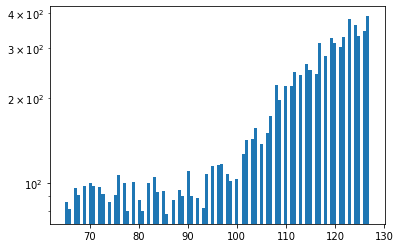

In [ ]:
plt.hist([len(s.numpy().split()) for s,y in dataset],log=True, bins=100)
plt.show()

In [ ]:
def data_to_numpy(data, num):
    sentences = []
    labels = []
    i=0
    for sentence, label in data:
        sentences.append(str(sentence.numpy()))
        labels.append(label.numpy())
        i=i+1
        if i >= num:
            break
    labels_np = np.array(labels)
    
    return sentences, labels_np

In [ ]:
num_samples = 10000
training_sentences, training_labels = data_to_numpy(dataset, num_samples)

In [ ]:
num_samples = len(training_sentences)
seq_len = 128
num_samples

10000

In [ ]:
from transformers import BertTokenizer

# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', cache_dir=path)
# tokenize - this time returning Numpy tensors
tokens = tokenizer(training_sentences, max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True, return_token_type_ids=False,
                   return_tensors='tf')

In [ ]:
tokens

{'input_ids': <tf.Tensor: shape=(10000, 128), dtype=int32, numpy=
array([[ 101,  171,  112, ...,    0,    0,    0],
       [ 101,  171,  107, ..., 2712,  119,  102],
       [ 101,  171,  112, ..., 3202,  119,  102],
       ...,
       [ 101,  171,  107, ..., 1105, 1199,  102],
       [ 101,  171,  112, ...,    0,    0,    0],
       [ 101,  171,  112, ...,  165,  112,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(10000, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}

In [ ]:
BUFFER_SIZE = num_samples
BATCH_SIZE = 64

data = tf.data.Dataset.from_tensor_slices((tokens['input_ids'], tokens['attention_mask'], training_labels)).shuffle(BUFFER_SIZE)
data = data.batch(BATCH_SIZE, drop_remainder=False)

In [ ]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels
data = data.map(map_func)
SIZE = num_samples/BATCH_SIZE
SPLIT = 0.9

train = data.take(int(SIZE*SPLIT))
val = data.skip(int(SIZE*SPLIT))

del data

---

# Model Setup

In [ ]:
from transformers import TFAutoModel

In [ ]:
bert = TFAutoModel.from_pretrained('bert-base-cased')  #, output_hidden_states=False

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert.summary()

Model: "tf_bert_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def build_model(transformer):
 
    # Define weight initializer with a random seed to ensure reproducibility    
    # Define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(seq_len,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(seq_len,), 
                                                  name='attention_mask', 
                                                  dtype='int32')
    
    # DistilBERT outputs a tuple where the first element at index 0
    # represents the hidden-state at the output of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[1]
    
    # We only care about DistilBERT's output for the [CLS] token, which is located
    # at index 0.  Splicing out the [CLS] tokens gives us 2D data.
    cls_token = last_hidden_state
    
    D1 = tf.keras.layers.Dropout(0.1)(cls_token)
    
    D2 = tf.keras.layers.Dropout(0.2
                                )(D1)
    
    D3 = tf.keras.layers.Dense(32,
                              activation='relu',
                              )(D2)
    
    D4 = tf.keras.layers.Dropout(0.1
                                )(D3)
    
    # Define a single node that makes up the output layer (for binary classification)
    output = tf.keras.layers.Dense(1,  activation='sigmoid')(D4)
    
    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.00001), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
# Freeze BERT layers to preserve pre-trained weights 
for layer in bert.layers:
    layer.trainable = True
model = build_model(bert)

In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                        

In [ ]:
history = model.fit(train,  validation_data=val, epochs=4)

Epoch 1/4
140/140 [==============================] - 151s 942ms/step - loss: 0.4079 - accuracy: 0.8029 - val_loss: 0.2313 - val_accuracy: 0.9183
Epoch 2/4
140/140 [==============================] - 129s 919ms/step - loss: 0.2277 - accuracy: 0.9172 - val_loss: 0.1200 - val_accuracy: 0.9673
Epoch 3/4
140/140 [==============================] - 129s 918ms/step - loss: 0.1670 - accuracy: 0.9445 - val_loss: 0.0884 - val_accuracy: 0.9740
Epoch 4/4
140/140 [==============================] - 129s 919ms/step - loss: 0.1222 - accuracy: 0.9621 - val_loss: 0.0743 - val_accuracy: 0.9779


# Evaluate

In [ ]:
# test the data
def evaluate(sentence):
  tokens = tokenizer(sentence, max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True, return_token_type_ids=False,
                   return_tensors='tf')
  output = model((tokens.input_ids, tokens.attention_mask))
  if output > 0.5:
     tag = "Positive"
  else:
     tag = "Neagtive"
  return tag, output[0][0].numpy()

In [ ]:
sentence = 'The movie was bad, expected it to be good.'
print(f'The above movie review : {evaluate(sentence)}')

The above movie review : ('Neagtive', 0.15311772)


In [ ]:
sentence = 'The movie was good, expected it to be bad.'
print(f'The above movie review : {evaluate(sentence)}')

The above movie review : ('Positive', 0.57513165)
